In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



## Data are separated by participant
Each file contains the following information
sequential number, x acceleration, y acceleration, z acceleration, label
Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing


In [115]:
df_all = pd.read_csv("1.csv", names=["Sequence", "x", "y", "z","label"])
df_all=df_all.drop('Sequence',axis=1)
df_all.head()

,x,y,z,label
0,1502,2215,2153,1
1,1667,2072,2047,1
2,1611,1957,1906,1
3,1601,1939,1831,1
4,1643,1965,1879,1


#### Class Distribution 

<AxesSubplot:xlabel='label', ylabel='count'>

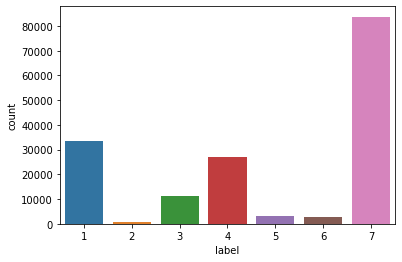

In [116]:
sns.countplot(x = 'label', data=df_all)

<AxesSubplot:xlabel='label', ylabel='count'>

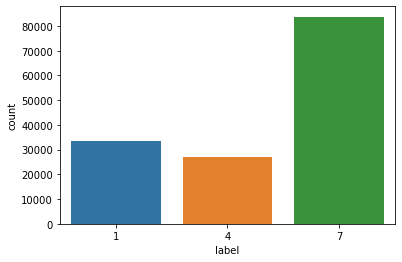

In [117]:
options=[1,4,7]
df= df_all.loc[df_all['label'].isin(options)]
sns.countplot(x = 'label', data=df)

In [118]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print(X.shape)

(144285, 3)


<bound method NDFrame.head of            x     y     z  label
0       1502  2215  2153      1
1       1667  2072  2047      1
2       1611  1957  1906      1
3       1601  1939  1831      1
4       1643  1965  1879      1
...      ...   ...   ...    ...
251239  1927  2401  2039      4
251240  1902  2390  2023      4
251241  1848  2482  2068      4
251242  1864  2317  2017      4
251243  1899  2489  2020      4

[251244 rows x 4 columns]>


<AxesSubplot:xlabel='label', ylabel='count'>

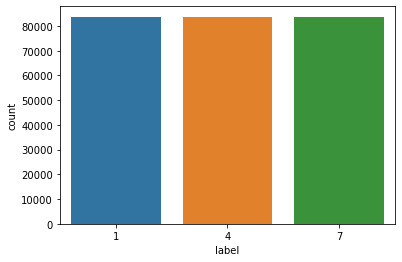

In [119]:
#Over Sample
ros= RandomOverSampler(random_state=0)
ros.fit(X,y)
X_resampled, y_resampled = ros.fit_sample(X,y)
df_resample = pd.concat([X_resampled,y_resampled], axis = 1)
print(df_resample.head)
sns.countplot(x = 'label', data=df_resample)

#### Encode Output
Pytorch supports labels from 0. [0,n]
- Dictionary class2idx , .replace method to change it, idx2class for reverse mapping

In [120]:
class2idx = {
    1:0,
    4:1,
    7:2
}

idx2class = {v: k for k, v in class2idx.items()}  # will be used later for reverse mapping

df_resample['label'].replace(class2idx, inplace=True)

In [121]:
df_resample.head(-5)
#df_resample.to_csv(r'C:\Users\antonebert\Desktop\WS2021 Programing\MADI\file.csv', index= None, header=True)

,x,y,z,label
0,1502,2215,2153,0
1,1667,2072,2047,0
2,1611,1957,1906,0
3,1601,1939,1831,0
4,1643,1965,1879,0
...,...,...,...,...
251234,1848,2385,2026,1
251235,1919,2285,2035,1
251236,1907,2317,2001,1
251237,1869,2238,2001,1


In [122]:
#Create input output data
X = df_resample.iloc[:, 0:-1]
y = df_resample.iloc[:, -1]

#### Stratification
Let’s assume you are doing a multiclass classification and have an imbalanced dataset that has 5 different classes. You do a simple train-test split that does a random split totally disregarding the distribution or proportions of the classes. What happens in this scenario is that you end up with a train and a test set with totally different data distributions. A model trained on a vastly different data distribution than the test set will perform inferiorly at validation. 
For more info: https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

In [123]:
# Split into train+val (80%) and test(20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69) 

# Split train into train-val(train 72%, val 8%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


#### fit: transform: fit_transform:

"fit" computes the mean and std to be used for later scaling. (just a computation), nothing is given to you. 
"transform" uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). 
"fit_transform" does both at the same time.

#### Note:
We use .fit_transform() on X_train while we use .transform() on X_val and X_test.
We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage.


In [124]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) #mean and std used later to autoscale
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Not Required after Upsampling
def get_class_distribution(obj):
    count_dict = {
        "act_1": 0,
        "act_2": 0,
        "act_3": 0,
        "act_4": 0,
        "act_5": 0,
        "act_6": 0,
        "act_7": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['act_1'] += 1
        elif i == 1: 
            count_dict['act_2'] += 1
        elif i == 2: 
            count_dict['act_3'] += 1
        elif i == 3: 
            count_dict['act_4'] += 1
        elif i == 4: 
            count_dict['act_5'] += 1  
        elif i == 5: 
            count_dict['act_6'] += 1  
        elif i == 6: 
            count_dict['act_7'] += 1
        else:
            print("Check classes.")
            
    return count_dict

#### Not Required after Upsampling
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
##### Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
##### Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
##### Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [125]:
#sns.countplot(x = 'label', data=df_resample)

## Neural Network

In [126]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
print(target_list)
target_list = target_list[torch.randperm(len(target_list))]
print(target_list)
print(target_list.shape)

Weight each class
Reciprocal of each count to obtain it’s weight.
WeightedRandomSampler expects a weight for each sample

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)
print(class_weights.shape)

class_weights_all = class_weights[target_list]
print(class_weights_all)


weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
print(weighted_sampler)

In [127]:
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.07
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3
print(NUM_FEATURES)
print(NUM_CLASSES)

3
3


#### Dataloader

In [128]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

#### Define Neural Net Architechture

In [129]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [130]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [131]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Train Model

In [132]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [133]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Training....")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Training....


Epoch 001: | Train Loss: 0.55362 | Val Loss: 0.32672 | Train Acc: 93.353| Val Acc: 91.667


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

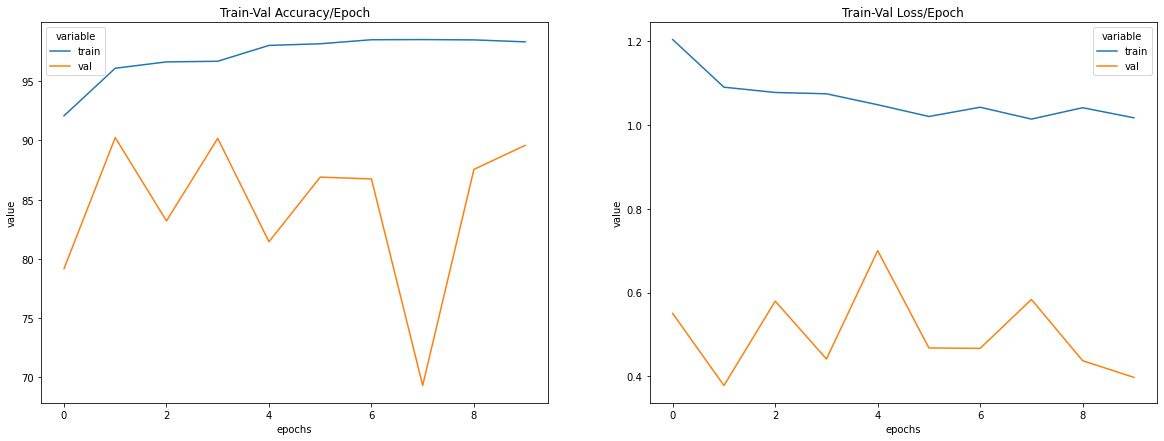

In [25]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [26]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

      1  2     3     4    5    6      7
1  6522  0     0   213    0    0      0
2     3  0     0   183    0    0      0
3     1  0  1335   829   42   29      0
4     2  0   111  5196   63    0      0
5     0  0    96    22  411  109      0
6     0  0   146     5  139  293      0
7     0  0   948     0   13  474  15315


<AxesSubplot:>

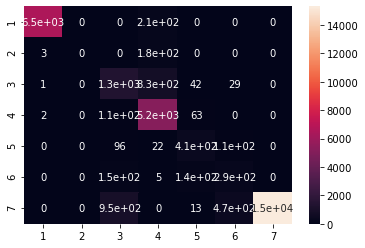

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
print(confusion_matrix_df)
sns.heatmap(confusion_matrix_df, annot=True)

In [28]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6735
           1       0.00      0.00      0.00       186
           2       0.51      0.60      0.55      2236
           3       0.81      0.97      0.88      5372
           4       0.62      0.64      0.63       638
           5       0.32      0.50      0.39       583
           6       1.00      0.91      0.96     16750

    accuracy                           0.89     32500
   macro avg       0.61      0.66      0.63     32500
weighted avg       0.91      0.89      0.90     32500



C:\Users\antonebert\anaconda3\envs\madi4\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0: Working at Computer

1: x Standing Up, Walking and Going updown stairs x

2: Standing

3: Walking

4: x Going UpDown Stairs x

5: x Walking and Talking with Someone x

6: Talking while Standing

Data are separated by participant
Each file contains the following information sequential number, x acceleration, y acceleration, z acceleration, label Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing

              precision    recall  f1-score   support

           1       1.00      0.97      0.98      6735
           2       0.00      0.00      0.00       186
           3       0.51      0.60      0.55      2236
           4       0.81      0.97      0.88      5372
           5       0.62      0.64      0.63       638
           6       0.32      0.50      0.39       583
           7       1.00      0.91      0.96     16750

    accuracy                           0.89     32500
   macro avg       0.61      0.66      0.63     32500
weighted avg       0.91      0.89      0.90     32500